In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
colab_flag = True

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/CDV/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/CDV


In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if gpus:
        gpu_to_use = 0
        tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        print(logical_devices)

[]


In [8]:
from tools.misc_tools import create_CDV_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_AR_v2 import AR_RNN_GRU as RNN_GRU

In [9]:
# behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
behaviour = 'loadFinalNetAndPlot'

In [10]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [11]:
print(tf.test.gpu_device_name())
print(tf.__version__)


2.9.2


# Lorenz System

In [293]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '001'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_007'

    # reading simulation parameters
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False

    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [294]:
# overriding T from ae params
T = 800

In [295]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [296]:
n = len(boundary_idx_arr)

# Autoencoder

In [297]:
from tools.ae_v3 import Autoencoder

In [298]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [299]:
ae_net = Autoencoder(12, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [300]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

2501/2501 [==============================] - 4s 2ms/step


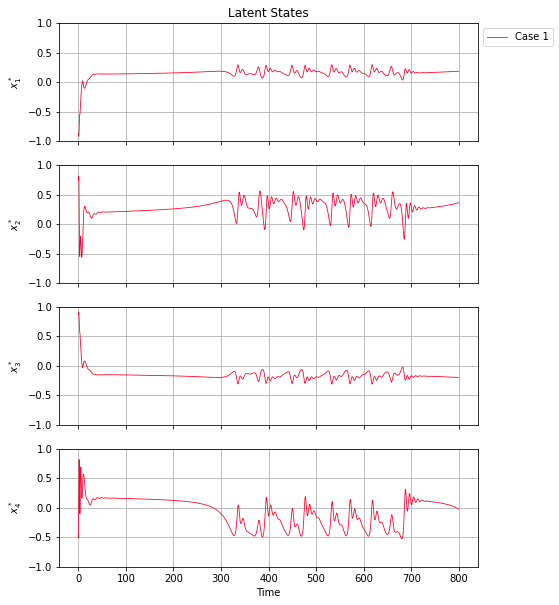

In [301]:
fig, ax = plot_latent_states_cdv(
    boundary_idx_arr,
    latent_states_all,
    all_data,
    delta_t,
    params_mat,
    # xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10,
    legend_bbox_to_anchor=[1,1],
    save_config_path=None
)

In [302]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [303]:
T_sample_input = 50.1*dt_rnn
T_sample_output = 150
T_offset = T_sample_input

In [304]:
# cutting off initial transient
initial_t0 = np.array([400])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = (initial_t0[i] + 0.25*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    begin_idx = boundary_idx_arr[i]
    len_relevant_idx += begin_idx - initial_idx[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=np.int32)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [305]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all[relevant_idx],
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr-initial_idx,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']

if normalize_dataset == True:
    with open(dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'rnn_normalization.txt') as f:
        lines = f.readlines()

    norm_dict = eval(''.join(lines))
    normalization_arr = norm_dict['normalization_arr']
    
    for i in range(latent_states_all.shape[1]):
        data_rnn_input[:, :, i] -= normalization_arr[0, i]
        data_rnn_input[:, :, i] /= normalization_arr[1, i]
        # data_rnn_output[:, :, i] -= normalization_arr[0, i]
        # data_rnn_output[:, :, i] /= normalization_arr[1, i]
else:
    normalization_arr=None

In [306]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [307]:
idx = np.arange(num_samples)
# np.random.shuffle(idx)
boundary = int(np.round(
    (1-test_split) * num_samples
))

# defining shapes
training_input_shape = [boundary*len(boundary_idx_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [boundary*len(boundary_idx_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

for i in range(len(boundary_idx_arr)):
    np.random.shuffle(idx)

    training_data_rnn_input[i*boundary:(i+1)*boundary] = data_rnn_input[i*num_samples + idx[0:boundary]]
    training_data_rnn_output[i*boundary:(i+1)*boundary] = data_rnn_output[i*num_samples + idx[0:boundary]]

    testing_data_rnn_input[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_input[i*num_samples + idx[boundary:]]
    testing_data_rnn_output[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_output[i*num_samples + idx[boundary:]]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [308]:
# Initialize network
load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
rnn_net = RNN_GRU(
    load_file=load_file,
    T_input=T_sample_input,
    T_output=T_sample_output,
#     normalization_arr=normalization_arr,
)

if behaviour == 'loadCheckpointAndContinueTraining':
    wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
elif behaviour == 'loadFinalNetAndPlot':
    wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
    # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'

# this forces the model to initialize its kernel weights/biases
temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
# this loads just the kernel wieghts and biases of the model
rnn_net.load_weights_from_file(wt_file)

# rnn_net = tf.keras.models.load_model(wt_file)

2/2 [==============================] - 146s 224ms/step


In [309]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0],
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [310]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

In [311]:
# if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining' or True:
#     test_loss = rnn_net.evaluate(
#         testing_data_rnn_input, testing_data_rnn_output,
#     )

In [312]:
# rnn_net.save_weights(save_path+dir_sep+'final_net_lstm_weights')
# rnn_net.save(save_path+dir_sep+'f2')

In [313]:
%pdb

Automatic pdb calling has been turned ON


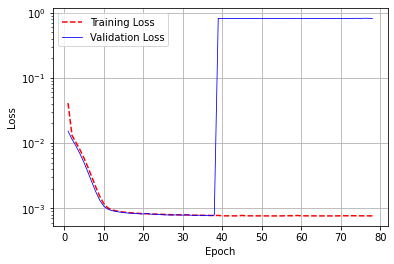

In [314]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

# plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [315]:
# data_idx = np.arange(testing_data_rnn_output.shape[0])
# np.random.shuffle(data_idx)
# data_idx = data_idx[0]
# # data_idx = 10
# print('data_idx : {}'.format(data_idx))


# plt.plot(testing_data_rnn_output[data_idx, :, 0], testing_data_rnn_output[data_idx, :, 1], color='C0')
# plt.plot(testing_data_rnn_output[data_idx, 0, 0], testing_data_rnn_output[data_idx, 0, 1], marker='o', color='C0')

# plt.plot(testing_data_rnn_input[data_idx, 0, 0], testing_data_rnn_input[data_idx, 0, 1], marker='x', color='C1')

# prediction = rnn_net.predict(testing_data_rnn_input[data_idx:data_idx+1, :, :])
# plt.plot(prediction[0, :, 0], prediction[0, :, 1], color='C2')
# plt.plot(prediction[0, 0, 0], prediction[0, 0, 1], marker='o', color='C2')

# plt.grid(True)
# plt.show()

In [316]:
# # data_type = 'training'
# data_type = 'testing'

# didx1 = 0
# didx2 = 1

# data_in = eval(data_type+'_data_rnn_input')
# data_out = eval(data_type+'_data_rnn_output')

# data_idx = np.arange(data_in.shape[0])
# np.random.shuffle(data_idx)
# data_idx = data_idx[0]
# # data_idx = 10
# print('data_idx : {}'.format(data_idx))

# ### initial point
# plt.plot(
#     data_in[data_idx, :, didx1]*normalization_arr[1, didx1]+normalization_arr[0, didx1],
#     data_in[data_idx, :, didx2]*normalization_arr[1, didx2]+normalization_arr[0, didx2],
#     'o', color='C1')

# ### actual trajectory
# plt.plot(data_out[data_idx, 0, didx1], data_out[data_idx, 0, didx2], 'o', color='C0')
# plt.plot(data_out[data_idx, :, didx1], data_out[data_idx, :, didx2], color='C0')

# ### predicted trajectory
# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# # plt.plot([data_in[data_idx, :, 0], ].extend(prediction[0, :, 0]), [data_in[data_idx, :, 1], ].extend(prediction[0, :, 1]))
# plt.plot(prediction[0, :, didx1], prediction[0, :, didx2], color='C2')
# plt.plot(prediction[0, 0, didx1], prediction[0, 0, didx2], 'o', color='C2')

# plt.grid(True)
# plt.show()

In [317]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

data_idx : 1397


Text(0.5, 1.0, 'Latent States')

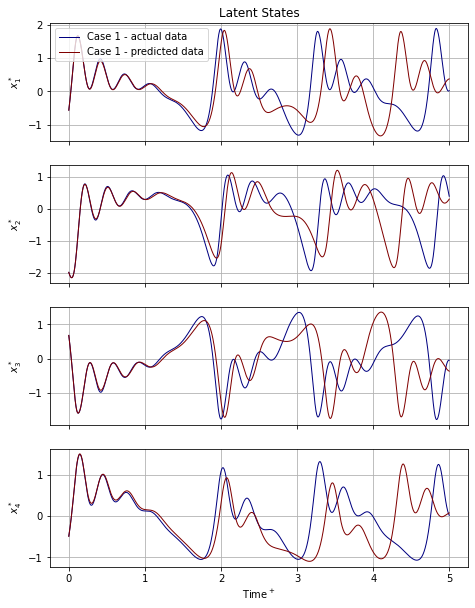

In [342]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
data_idx = 1397
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
data_out = rescale_data(data_out, normalization_arr)

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_1$', '$x^*_2$', '$x^*_3$', '$x^*_4$', '$x^*_5$', '$x^*_6$']

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/30

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
# plt.figlegend(
#     handles=mpl_ax_artist_list[0:n],
#     # bbox_to_anchor=[1.1,0.85],
#     loc=legend_loc,
#     bbox_to_anchor=legend_bbox_to_anchor,
#     ncol=ncols,
#     markerscale=legend_markerscale
# )
ax[0].legend(
    # handles=mpl_ax_artist_list[0:n],
    # bbox_to_anchor=[1.1,0.85],
    loc='best',
    # bbox_to_anchor=legend_bbox_to_anchor,
    ncol=ncols,
    # markerscale=legend_markerscale
)
# fig.suptitle(r'Latent States', size=12)
ax[0].set_title(r'Latent States', size=12)
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')

In [319]:
type(prediction)

tensorflow.python.framework.ops.EagerTensor